# Giới thiệu phân phối SinhArcsinh
BS Vương Kiến Thanh

Phân phối SinhArcsinh được giới thiệu bởi Chris Jones và Arthur Pewsey vào năm 2009 như một dạng tổng quát hoá của phân phối normal. Trong khi phân phối normal là đối xứng, có hai đuôi từ nhỏ đến vừa và có thể được định nghĩa bằng chỉ hai tham số ($\mu$-`loc` và $\sigma$-`scale`), phân phối SinhArcsinh cần thêm hai tham số để kiểm soát độ lệch ($\nu$-`skewness`) và trọng lượng của đuôi ($\tau$-`tailweight`).

Các bạn có thể nhìn thấy ảnh hưởng của các tham số `nu` ($\nu$) và `tau`($\tau$) ở các hình sau:
![](https://statisticaloddsandends.files.wordpress.com/2019/04/fig2.png)
![](https://statisticaloddsandends.files.wordpress.com/2019/04/fig1.png)
![](https://statisticaloddsandends.files.wordpress.com/2019/04/fig3.png)

`tensorflow` đã chuyển nó thành một dạng transformation để sử dụng được với tất cả các phân phối khác. Gần đây, `numpyro` đã cho phép sử dụng các phân phối có trong `tensorflow` để suy luận Bayes.

Hôm nay tôi sẽ dùng phân phối này để suy luận tham số của một biến X. Biến X có phân phối lệch (T) và có một đuôi rất nhỏ.

In [86]:
import numpy as np
import pandas as pd
import seaborn as sns
import arviz as az
import numpyro
import numpyro.distributions as dist
import numpyro.contrib.tfp.distributions as tfd
from numpyro.infer import MCMC, NUTS, Predictive
from jax import random
import jax.numpy as jnp
import matplotlib.pyplot as plt
az.style.use('fivethirtyeight')

## Mô phỏng biến X

In [78]:
x = np.concatenate([
    np.random.uniform(0,1, 100),
    np.random.normal(1.1,0.1,50),
    np.random.normal(0.9,0.1,500)
])

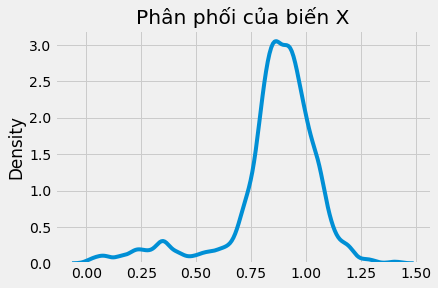

In [79]:
sns.kdeplot(x, bw_adjust=0.5)
plt.title('Phân phối của biến X');

## Suy luận
Ta đặt prior cho 4 tham số, vì giá trị của mình khoảng nhỏ nên prior của `loc` cũng đặt gần giá trị 1.

In [81]:
def model(x=None):
    loc = numpyro.sample('loc', dist.Normal(1,1))
    scale = numpyro.sample('scale', dist.Exponential(1))
    skewness = numpyro.sample('skewness', dist.Normal(0,1))
    tailweight = numpyro.sample('tailweight', dist.Exponential(1))
    numpyro.sample('x',
                   tfd.SinhArcsinh(loc, scale, skewness, tailweight,
                                   distribution=tfd.Normal(0,1)),
                   obs=x
                  )
mcmc = MCMC(NUTS(model), 500,1000, 4,chain_method="sequential")
mcmc.run(random.PRNGKey(1), x=x)
mcmc.print_summary()

sample: 100%|██████████| 1500/1500 [00:03<00:00, 492.91it/s, 7 steps of size 4.26e-01. acc. prob=0.93] 



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
         loc      0.92      0.01      0.92      0.91      0.93   2166.88      1.00
       scale      0.20      0.01      0.20      0.18      0.22   1844.56      1.00
    skewness     -0.25      0.04     -0.25     -0.31     -0.19   1960.84      1.00
  tailweight      1.74      0.08      1.74      1.59      1.86   1820.59      1.00

Number of divergences: 0


## Kiểm tra converge của các chuỗi MCMC.

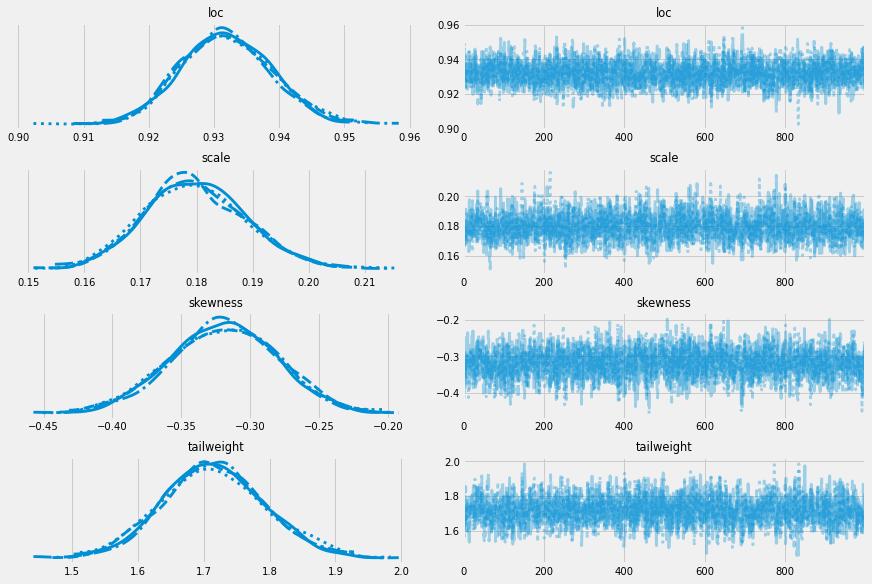

In [41]:
az.plot_trace(mcmc);

## Kiểm tra fit của model

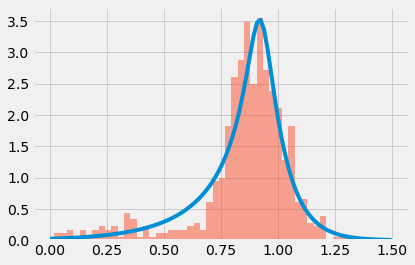

In [85]:
post = mcmc.get_samples()
x_seq = np.linspace(0,1.5,100)
plt.plot(x_seq,
         np.exp(tfd.SinhArcsinh(
             post['loc'].mean(),
             post['scale'].mean(),
             post['skewness'].mean(),
             post['tailweight'].mean()
         ).log_prob(x_seq)))
plt.hist(x, density=True, bins=50, alpha=0.5);

# Tổng kết:
Phân phối SinhArcsinh là một phân phối rất flexible. R package `gamlss` đã ứng dụng nó làm phân phối chính, kết hợp thêm các kỹ thuật trong GAM để suy luận.  

Trong bối cảnh Generalized Linear Model, phân phối này là một phân phối hữu ích, bên cạnh Gamma Regression, Beta Regression. Để thành "SinhArcsinh regression", các bạn chỉ cần thêm linear model vào tham số `loc` như các GLM khác.

Chúc các bạn thành công.

In [90]:
dist.transforms.AbsTransform

numpyro.distributions.transforms.AbsTransform

In [94]:
a = dist.TransformedDistribution(
    tfd.SinhArcsinh(0,1,0,1),
    dist.transforms.AbsTransform())

In [97]:
a.log_prob(1)

NotImplementedError: 